In [1]:
import numpy as np
import pandas as pd
from scipy.stats import kstest,ttest_ind, fisher_exact
from scipy.stats.contingency import odds_ratio
import itertools as it
from collections import Counter
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages
from functools import reduce
from scipy.stats import kstest,ttest_ind


In [2]:
phenotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british/train_cohort_bmi.csv.gz"
cohort_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo2.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo3.csv"
]

phenotype_df = pd.read_csv(phenotype_file, usecols=["sample_names", "bmi", "bmi_prs"])
phenotype_df["bmi_decile"] = pd.qcut(phenotype_df.bmi, q=10, labels=False)

cohort_df = pd.concat([pd.read_csv(cf) for cf in cohort_files])
all_combo_samples = set("|".join(cohort_df.combo_samples.values).split("|"))

phenotype_combo_samples_df = phenotype_df.loc[phenotype_df.sample_names.astype(str).isin(list(map(str, all_combo_samples)))]
phenotype_other_samples_df = phenotype_df.loc[~phenotype_df.sample_names.astype(str).isin(list(map(str, all_combo_samples)))]

phenotype_other_samples_df["description"] = "Non Combo"
phenotype_combo_samples_df["description"] = "Combo"
phenotype_samples_df = pd.concat((phenotype_combo_samples_df, phenotype_other_samples_df))

/tmp/ipykernel_50945/2552700270.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_other_samples_df["description"] = "Non Combo"
/tmp/ipykernel_50945/2552700270.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotype_combo_samples_df["description"] = "Combo"


In [3]:
top_decile = phenotype_samples_df.loc[phenotype_samples_df.bmi_decile==9]

In [4]:
top_decile.loc[top_decile.description=="Non Combo", "bmi_prs"].mean(), top_decile.loc[top_decile.description=="Combo", "bmi_prs"].mean()

(0.3151901379159104, 0.33171705961669834)

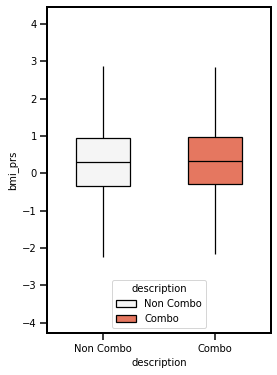

In [5]:
fig,ax = plt.subplots(1, 1, figsize=(4, 6))
## BMI prs box plots
sns_ax = sns.boxplot(
    top_decile, x="description", y="bmi_prs", hue="description", order=["Non Combo", "Combo"], hue_order=["Non Combo", "Combo"],
    width=0.65, linewidth=1.25, fliersize=0, capprops={'color':'none'}, boxprops={'edgecolor':'k'},
    medianprops={'color':'k'},
    linecolor='k',
    palette= ["whitesmoke", sns.color_palette("Reds", 15).as_hex()[7]],
    legend=True, gap=0.25, ax=ax)

(29.0, 47.0)

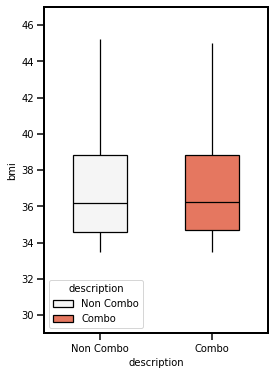

In [6]:
fig,ax = plt.subplots(1, 1, figsize=(4, 6))
## BMI prs box plots
sns_ax = sns.boxplot(
    top_decile, x="description", y="bmi", hue="description", order=["Non Combo", "Combo"], hue_order=["Non Combo", "Combo"],
    width=0.65, linewidth=1.25, fliersize=0, capprops={'color':'none'}, boxprops={'edgecolor':'k'},
    medianprops={'color':'k'},
    linecolor='k',
    palette= ["whitesmoke", sns.color_palette("Reds", 15).as_hex()[7]],
    legend=True, gap=0.25, ax=ax)

ax.set_ylim(29, 47)

In [7]:
nc_bmi, c_bmi = top_decile.loc[top_decile.description=="Non Combo", "bmi"], top_decile.loc[top_decile.description=="Combo", "bmi"]
nc_bmi.mean(), c_bmi.mean()

(37.34715077182705, 37.36915167405999)

In [8]:
ttest_ind(nc_bmi, c_bmi, alternative="less")

TtestResult(statistic=-0.31205663178210813, pvalue=0.37749950317737, df=42757.0)

In [9]:
kstest(nc_bmi, c_bmi, alternative="greater")

KstestResult(statistic=0.02079119097345339, pvalue=0.07870833579985548, statistic_location=35.0513, statistic_sign=1)

In [10]:
top_decile_combo = top_decile.loc[top_decile.description=="Combo"]
top_decile_noncombo = top_decile.loc[top_decile.description=="Non Combo"]

In [11]:
table = [
    [len(top_decile_combo.loc[top_decile_combo.bmi_prs<0]), len(top_decile_combo.loc[top_decile_combo.bmi_prs>0])],
    [len(top_decile_noncombo.loc[top_decile_noncombo.bmi_prs<0]), len(top_decile_noncombo.loc[top_decile_noncombo.bmi_prs>0])]
    ]

In [12]:
df = pd.DataFrame(table, columns=["Negative PRS", "Positive PRS"], index=["Combo", "Non Combo"])

In [13]:
df

,Negative PRS,Positive PRS
Combo,1156,2000
Non Combo,14605,24998


In [14]:
fisher_exact(df)

SignificanceResult(statistic=0.9893080451900034, pvalue=0.7884246404043256)

In [15]:
lf_df = pd.read_csv("/data6/deepro/ukb_bmi/0_data_preparation_and_download/lifestyle_factors/data/lifestyle_processed/filtered_lifestyle_binarized.csv.gz")

In [16]:
top_decile_combo_lf = top_decile_combo.merge(lf_df, left_on="sample_names", right_on="Sample_Name")
top_decile_noncombo_lf = top_decile_noncombo.merge(lf_df, left_on="sample_names", right_on="Sample_Name")

In [17]:
def get_table(top_decile_combo_lf, top_decile_noncombo_lf, field):
    table = [
        [len(top_decile_combo_lf.loc[top_decile_combo_lf[field]==0]), len(top_decile_combo_lf.loc[top_decile_combo_lf[field]==1])],
        [len(top_decile_noncombo_lf.loc[top_decile_noncombo_lf[field]==0]), len(top_decile_noncombo_lf.loc[top_decile_noncombo_lf[field]==1])]
    ]
    df = pd.DataFrame(table, columns=[f"No {field}", f"{field}"], index=["Combo", "Non Combo"])
    return df

In [18]:
lf_df

,Sample_Name,alcohol,met,sleep,cookedvegetable,salad,freshfruit,driedfruit,poultry,bread,cereal,tea,coffee,water,smoke,fish,meat,sedentary
0,1270557,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4366755,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5448800,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,3351884,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2896181,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502363,4729190,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
502364,1443003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
502365,2614361,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
502366,1927454,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
lf_fields_check = ["alcohol", "met", "sleep", "smoke", "meat", "sedentary"]

In [20]:
tables = [get_table(top_decile_combo_lf, top_decile_noncombo_lf, field) for field in lf_fields_check]

In [21]:
test_res = [fisher_exact(table) for table in tables]

In [22]:
tables

[           No alcohol  alcohol
 Combo            2789      367
 Non Combo       34948     4655,
            No met   met
 Combo        2437   719
 Non Combo   30767  8836,
            No sleep  sleep
 Combo          3076     80
 Non Combo     38366   1237,
            No smoke  smoke
 Combo          2948    208
 Non Combo     37036   2567,
            No meat  meat
 Combo         2984   172
 Non Combo    37671  1932,
            No sedentary  sedentary
 Combo              2890        266
 Non Combo         36297       3306]

In [23]:
test_res

[SignificanceResult(statistic=1.0122314070979415, pvalue=0.8631572241685213),
 SignificanceResult(statistic=0.9734131176526988, pvalue=0.5488839269629142),
 SignificanceResult(statistic=1.2397083355053955, pvalue=0.06856141917894581),
 SignificanceResult(statistic=0.9823492942417772, pvalue=0.7927909525113108),
 SignificanceResult(statistic=0.8897548110847096, pvalue=0.15807641520793742),
 SignificanceResult(statistic=0.9895741088401638, pvalue=0.8672833147403021)]

In [24]:
genotype_df = pd.read_csv("/data6/deepro/ukb_bmi/0_data_preparation_and_download/exome_annot/data/processed_burden/all_gene_burden.csv.gz")

In [25]:
rvas_studies = [
    "/data6/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/akbari_2021/data/akbari_genes.list",
    "/data6/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/locke/data/locke_genes.txt",
    "/data6/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/marenne/data/marenne_genes.txt",
    "/data6/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/turcot_2018/data/turcot_genes.list",
    # "/data6/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/gwas/data/gwas_genes.txt",
    # "/data6/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/mgi/data/mgi_genes.txt"

]

In [26]:
combo_genes = set("|".join(cohort_df.uniq_items.str.replace("Input_", "")).split("|"))

In [27]:
def get_rvas_gene(gene_file):
    with open(gene_file, "r") as f:
        genes = set([l.strip() for l in f.readlines()])
    return genes

rvas_genes = reduce(lambda x,y: x.union(y), [get_rvas_gene(gf) for gf in rvas_studies])


In [28]:
rvas_other_genes = rvas_genes.difference(combo_genes)

In [29]:
rvas_geno = genotype_df.loc[genotype_df.gene.isin(rvas_other_genes)]

In [30]:
all_rvas_samples = set(",".join(rvas_geno.samples).split(","))

In [31]:
combo_samples = set(top_decile_combo.sample_names.astype(str).values)
noncombo_samples = set(top_decile_noncombo.sample_names.astype(str).values)

In [37]:
table = [
    [len(combo_samples.difference(all_rvas_samples)), len(combo_samples.intersection(all_rvas_samples)), ],
     [len(noncombo_samples.difference(all_rvas_samples)), len(noncombo_samples.intersection(all_rvas_samples)), ]
    ]

In [38]:
df = pd.DataFrame(table, columns=["No RVAS", "RVAS"], index=["Combo", "Non Combo"])

In [39]:
df

,No RVAS,RVAS
Combo,2484,672
Non Combo,31799,7804


In [40]:
fisher_exact(df)

SignificanceResult(statistic=0.9071646457885019, pvalue=0.03280704306923551)

In [41]:
odds_ratio(df)

OddsRatioResult(statistic=0.9071667647498654)

In [4]:
2484+672

3156

In [3]:
672/(2484+672)

0.21292775665399238

In [5]:
7804/(31799+7804)

0.19705577860263113